<a href="https://colab.research.google.com/github/ldivrala/Uber-Lyft-Cab-prices/blob/main/CabPrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
!kaggle datasets download -d 'ravi72munde/uber-lyft-cab-prices'

uber-lyft-cab-prices.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!mkdir train
!unzip uber-lyft-cab-prices.zip -d train

mkdir: cannot create directory ‘train’: File exists
Archive:  uber-lyft-cab-prices.zip
replace train/Cab-Weather Data/Cab-Weather Data/cab_rides.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
# Reduce Memory Usage
def reduce_memory_usage(df):
  start_mem = df.memory_usage().sum() / 1024 ** 2
  for col in df.columns:
    col_type = df[col].dtype

    if col_type != object:
      c_min = df[col].min()
      c_max = df[col].max()

      if str(col_type)[:3] == 'int':
        if c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
          df[col] = df[col].astype(np.int16)
        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
          df[col] = df[col].astype(np.int32)
        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
          df[col] = df[col].astype(np.int64)
      else:
        if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
          df[col] = df[col].astype(np.float32)
        elif c_min > np.finfo(np.float64).min and c_max < np.finfo(np.float64).max:
          df[col] = df[col].astype(np.float64)

  end_mem = df.memory_usage().sum() / 1024 ** 2
  print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
  return df        

In [7]:
cab_data = pd.read_csv("train/cab_rides.csv")
cab_data = reduce_memory_usage(cab_data)
weather_data = pd.read_csv("train/weather.csv")
weather_data = reduce_memory_usage(weather_data)

Memory usage of dataframe is 52.88 MB --> 44.95 MB (Decreased by 15.0%)
Memory usage of dataframe is 0.38 MB --> 0.22 MB (Decreased by 43.7%)


In [8]:
cab_data.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [9]:
weather_data.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.419998,Back Bay,1.0,1012.140015,0.1228,1545003901,0.77,11.25
1,42.430000,Beacon Hill,1.0,1012.150024,0.1846,1545003901,0.76,11.32
2,42.500000,Boston University,1.0,1012.150024,0.1089,1545003901,0.76,11.07
3,42.110001,Fenway,1.0,1012.130005,0.0969,1545003901,0.77,11.09
4,43.130001,Financial District,1.0,1012.140015,0.1786,1545003901,0.75,11.49


In [10]:
cab_data.columns

Index(['distance', 'cab_type', 'time_stamp', 'destination', 'source', 'price',
       'surge_multiplier', 'id', 'product_id', 'name'],
      dtype='object')

In [11]:
weather_data.columns

Index(['temp', 'location', 'clouds', 'pressure', 'rain', 'time_stamp',
       'humidity', 'wind'],
      dtype='object')

In [12]:
# cab_data["time_stamp"] = pd.to_datetime(cab_data["time_stamp"])
# weather_data["time_stamp"] = pd.to_datetime(weather_data["time_stamp"])

In [13]:
cab_data.describe()

,distance,time_stamp,price,surge_multiplier
count,693071.000000,6.930710e+05,637976.000000,693071.000000
mean,2.190057,1.544046e+12,16.543797,1.013870
std,1.138935,6.891925e+08,9.319172,0.091467
min,0.020000,1.543204e+12,2.500000,1.000000
25%,1.280000,1.543444e+12,9.000000,1.000000
50%,2.160000,1.543737e+12,13.500000,1.000000
75%,2.920000,1.544828e+12,22.500000,1.000000
max,7.860000,1.545161e+12,97.500000,3.000000


In [14]:
weather_data.describe()

,temp,clouds,pressure,rain,time_stamp,humidity,wind
count,6276.000000,6276.000000,6276.000000,894.000000,6.276000e+03,6276.000000,6276.000000
mean,39.090378,0.677775,1008.443176,0.057652,1.543857e+09,0.763976,6.802810
std,6.022061,0.314283,12.870790,0.100758,6.659340e+05,0.127340,3.633476
min,19.620001,0.000000,988.250000,0.000200,1.543204e+09,0.450000,0.290000
25%,36.077501,0.440000,997.747498,0.004900,1.543387e+09,0.670000,3.517500
50%,40.130001,0.780000,1007.659973,0.014850,1.543514e+09,0.760000,6.570000
75%,42.832501,0.970000,1018.479980,0.060925,1.544691e+09,0.890000,9.920000
max,55.410000,1.000000,1035.119995,0.780700,1.545159e+09,0.990000,18.180000


Handle missing values

In [15]:
cab_data.isna().sum()

distance                0
cab_type                0
time_stamp              0
destination             0
source                  0
price               55095
surge_multiplier        0
id                      0
product_id              0
name                    0
dtype: int64

In [16]:
cab_data = cab_data.dropna(axis=0).reset_index(drop=True)
cab_data.isna().sum()

distance            0
cab_type            0
time_stamp          0
destination         0
source              0
price               0
surge_multiplier    0
id                  0
product_id          0
name                0
dtype: int64

In [17]:
weather_data.isna().sum()

temp             0
location         0
clouds           0
pressure         0
rain          5382
time_stamp       0
humidity         0
wind             0
dtype: int64

In [18]:
# Most of the rain value can be 0
weather_data = weather_data.fillna(0)

EDA

In [19]:
# Plot distrubution of Categorial Data
Categorical_Columns = cab_data.dtypes[cab_data.dtypes == "object"].index.to_list()
Categorical_Columns = [x for x in Categorical_Columns if x != "Churn"]
Categorical_Columns

['cab_type', 'destination', 'source', 'id', 'product_id', 'name']

In [38]:
Categorical_Columns = ['cab_type', 'destination', 'source', 'name']

In [21]:
Numerical_Columns  = cab_data.dtypes[cab_data.dtypes != "object"].index.to_list()
Continous_Columns = [column for column in Numerical_Columns if cab_data[column].nunique() > 10]
Discrete_Columns = [column for column in Numerical_Columns if cab_data[column].nunique() <= 10]

Discrete_Columns, Continous_Columns

(['surge_multiplier'], ['distance', 'time_stamp', 'price'])

In [22]:
Continous_Columns = Continous_Columns + Discrete_Columns

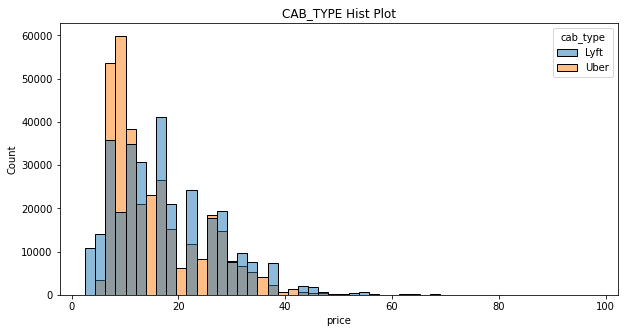

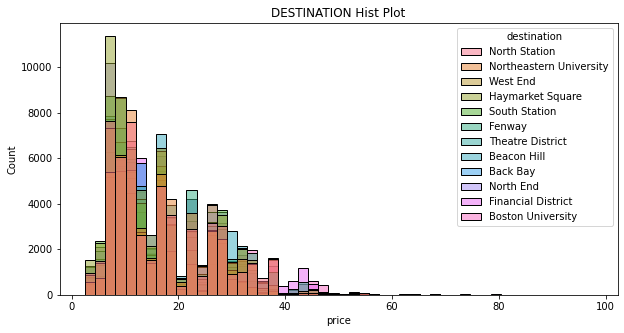

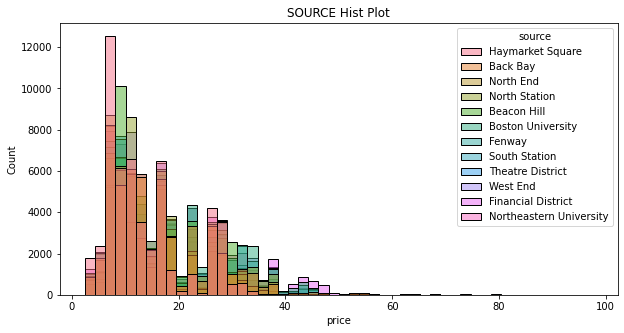

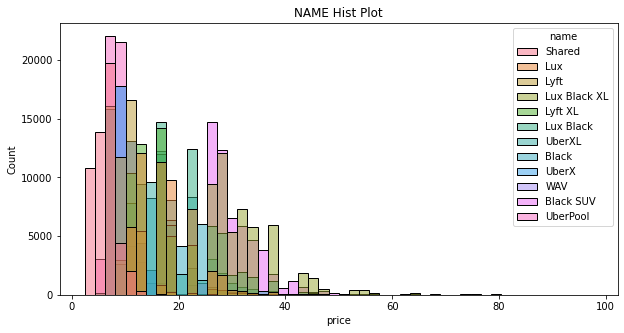

In [39]:
for i, column in enumerate(Categorical_Columns):
    plt.figure(i, figsize=(10, 5))
    ax = sns.histplot(data = cab_data, x='price', hue = cab_data[column], bins = 50, legend = True)

    plt.title(f"{column.upper()} Hist Plot")


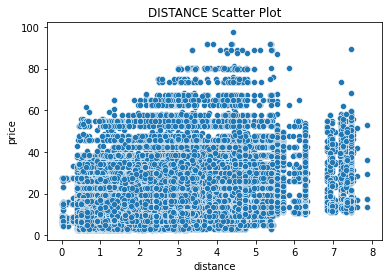

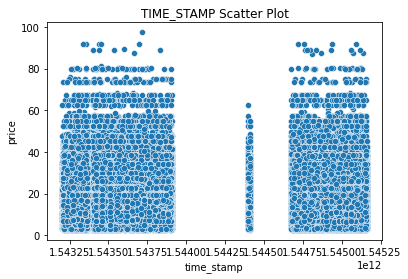

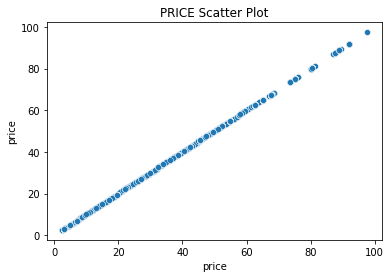

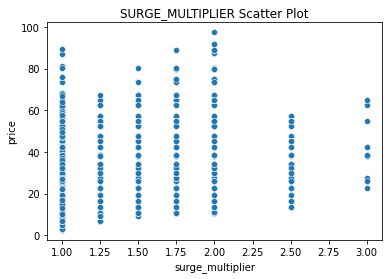

In [55]:
for i, column in enumerate(Continous_Columns):
    plt.figure(i)
    ax = sns.scatterplot(x=cab_data[column], y = cab_data['price'])

    plt.title(f"{column.upper()} Scatter Plot")

In [75]:
weather_data.groupby('location').mean()

,temp,clouds,pressure,rain,time_stamp,humidity,wind
location,,,,,,,
Back Bay,39.082123,0.678432,1008.447815,0.007925,1.543857e+09,0.764073,6.778528
Beacon Hill,39.047283,0.677801,1008.448364,0.008297,1.543857e+09,0.765048,6.810325
Boston University,39.047745,0.679235,1008.459229,0.007738,1.543857e+09,0.763786,6.692180
Fenway,38.964378,0.679866,1008.453308,0.007343,1.543857e+09,0.767266,6.711721
Financial District,39.410824,0.676730,1008.435791,0.008563,1.543857e+09,0.754837,6.860019
Haymarket Square,39.067898,0.676711,1008.445251,0.008660,1.543857e+09,0.764838,6.843193
North End,39.090843,0.676730,1008.441895,0.008644,1.543857e+09,0.764054,6.853117
North Station,39.035316,0.676998,1008.442810,0.008649,1.543857e+09,0.765545,6.835755
Northeastern University,38.975086,0.678317,1008.444153,0.007358,1.543857e+09,0.767648,6.749426


In [87]:
# Data is based on one week only so we will collect average data of weather
average_weather_data = weather_data.groupby('location').mean().reset_index()
average_weather_data = average_weather_data.drop('time_stamp', axis=1)
average_weather_data

,location,temp,clouds,pressure,rain,humidity,wind
0,Back Bay,39.082123,0.678432,1008.447815,0.007925,0.764073,6.778528
1,Beacon Hill,39.047283,0.677801,1008.448364,0.008297,0.765048,6.810325
2,Boston University,39.047745,0.679235,1008.459229,0.007738,0.763786,6.692180
3,Fenway,38.964378,0.679866,1008.453308,0.007343,0.767266,6.711721
4,Financial District,39.410824,0.676730,1008.435791,0.008563,0.754837,6.860019
5,Haymarket Square,39.067898,0.676711,1008.445251,0.008660,0.764838,6.843193
6,North End,39.090843,0.676730,1008.441895,0.008644,0.764054,6.853117
7,North Station,39.035316,0.676998,1008.442810,0.008649,0.765545,6.835755
8,Northeastern University,38.975086,0.678317,1008.444153,0.007358,0.767648,6.749426
9,South Station,39.394093,0.677495,1008.438049,0.008310,0.755468,6.848948


In [77]:
cab_data.head(10)

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL
5,0.44,Lyft,1545071112138,North Station,Haymarket Square,16.5,1.0,f6f6d7e4-3e18-4922-a5f5-181cdd3fa6f2,lyft_lux,Lux Black
6,1.08,Lyft,1543208580200,Northeastern University,Back Bay,10.5,1.0,462816a3-820d-408b-8549-0b39e82f65ac,lyft_plus,Lyft XL
7,1.08,Lyft,1543780384677,Northeastern University,Back Bay,16.5,1.0,474d6376-bc59-4ec9-bf57-4e6d6faeb165,lyft_lux,Lux Black
8,1.08,Lyft,1543818482645,Northeastern University,Back Bay,3.0,1.0,4f9fee41-fde3-4767-bbf1-a00e108701fb,lyft_line,Shared
9,1.08,Lyft,1543315522249,Northeastern University,Back Bay,27.5,1.0,8612d909-98b8-4454-a093-30bd48de0cb3,lyft_luxsuv,Lux Black XL


In [78]:
pickup_weather_data = average_weather_data.rename(
    columns={
        'location': 'source',
        'temp': 'source_temp',
        'clouds': 'source_clouds',
        'pressure': 'source_pressure',
        'rain': 'source_rain',
        'humidity': 'source_humidity',
        'wind': 'source_wind'
    }
)
pickup_weather_data

,source,source_temp,source_clouds,source_pressure,source_rain,source_humidity,source_wind
0,Back Bay,39.082123,0.678432,1008.447815,0.007925,0.764073,6.778528
1,Beacon Hill,39.047283,0.677801,1008.448364,0.008297,0.765048,6.810325
2,Boston University,39.047745,0.679235,1008.459229,0.007738,0.763786,6.692180
3,Fenway,38.964378,0.679866,1008.453308,0.007343,0.767266,6.711721
4,Financial District,39.410824,0.676730,1008.435791,0.008563,0.754837,6.860019
5,Haymarket Square,39.067898,0.676711,1008.445251,0.008660,0.764838,6.843193
6,North End,39.090843,0.676730,1008.441895,0.008644,0.764054,6.853117
7,North Station,39.035316,0.676998,1008.442810,0.008649,0.765545,6.835755
8,Northeastern University,38.975086,0.678317,1008.444153,0.007358,0.767648,6.749426
9,South Station,39.394093,0.677495,1008.438049,0.008310,0.755468,6.848948


In [79]:
destination_weather_data = average_weather_data.rename(
    columns={
        'location': 'destination',
        'temp': 'destination_temp',
        'clouds': 'destination_clouds',
        'pressure': 'destination_pressure',
        'rain': 'destination_rain',
        'humidity': 'destination_humidity',
        'wind': 'destination_wind'
    }
)

destination_weather_data

,destination,destination_temp,destination_clouds,destination_pressure,destination_rain,destination_humidity,destination_wind
0,Back Bay,39.082123,0.678432,1008.447815,0.007925,0.764073,6.778528
1,Beacon Hill,39.047283,0.677801,1008.448364,0.008297,0.765048,6.810325
2,Boston University,39.047745,0.679235,1008.459229,0.007738,0.763786,6.692180
3,Fenway,38.964378,0.679866,1008.453308,0.007343,0.767266,6.711721
4,Financial District,39.410824,0.676730,1008.435791,0.008563,0.754837,6.860019
5,Haymarket Square,39.067898,0.676711,1008.445251,0.008660,0.764838,6.843193
6,North End,39.090843,0.676730,1008.441895,0.008644,0.764054,6.853117
7,North Station,39.035316,0.676998,1008.442810,0.008649,0.765545,6.835755
8,Northeastern University,38.975086,0.678317,1008.444153,0.007358,0.767648,6.749426
9,South Station,39.394093,0.677495,1008.438049,0.008310,0.755468,6.848948


In [80]:
data = cab_data\
    .merge(pickup_weather_data, on='source')\
    .merge(destination_weather_data, on='destination')

data.head(8)

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,source_temp,source_clouds,source_pressure,source_rain,source_humidity,source_wind,destination_temp,destination_clouds,destination_pressure,destination_rain,destination_humidity,destination_wind
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,39.067898,0.676711,1008.445251,0.00866,0.764838,6.843193,39.035316,0.676998,1008.44281,0.008649,0.765545,6.835755
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,39.067898,0.676711,1008.445251,0.00866,0.764838,6.843193,39.035316,0.676998,1008.44281,0.008649,0.765545,6.835755
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,39.067898,0.676711,1008.445251,0.00866,0.764838,6.843193,39.035316,0.676998,1008.44281,0.008649,0.765545,6.835755
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,39.067898,0.676711,1008.445251,0.00866,0.764838,6.843193,39.035316,0.676998,1008.44281,0.008649,0.765545,6.835755
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,39.067898,0.676711,1008.445251,0.00866,0.764838,6.843193,39.035316,0.676998,1008.44281,0.008649,0.765545,6.835755
5,0.44,Lyft,1545071112138,North Station,Haymarket Square,16.5,1.0,f6f6d7e4-3e18-4922-a5f5-181cdd3fa6f2,lyft_lux,Lux Black,39.067898,0.676711,1008.445251,0.00866,0.764838,6.843193,39.035316,0.676998,1008.44281,0.008649,0.765545,6.835755
6,0.49,Uber,1543768980914,North Station,Haymarket Square,15.0,1.0,a03f131a-3136-4bb3-9fd4-5926ad8f5323,6c84fd89-3f11-4782-9b50-97c468b19529,Black,39.067898,0.676711,1008.445251,0.00866,0.764838,6.843193,39.035316,0.676998,1008.44281,0.008649,0.765545,6.835755
7,0.49,Uber,1543783380005,North Station,Haymarket Square,7.0,1.0,a140fd91-dae2-4b64-b547-04810fe5a433,9a0e7b09-b92b-4c41-9779-2ad22b4d779d,WAV,39.067898,0.676711,1008.445251,0.00866,0.764838,6.843193,39.035316,0.676998,1008.44281,0.008649,0.765545,6.835755


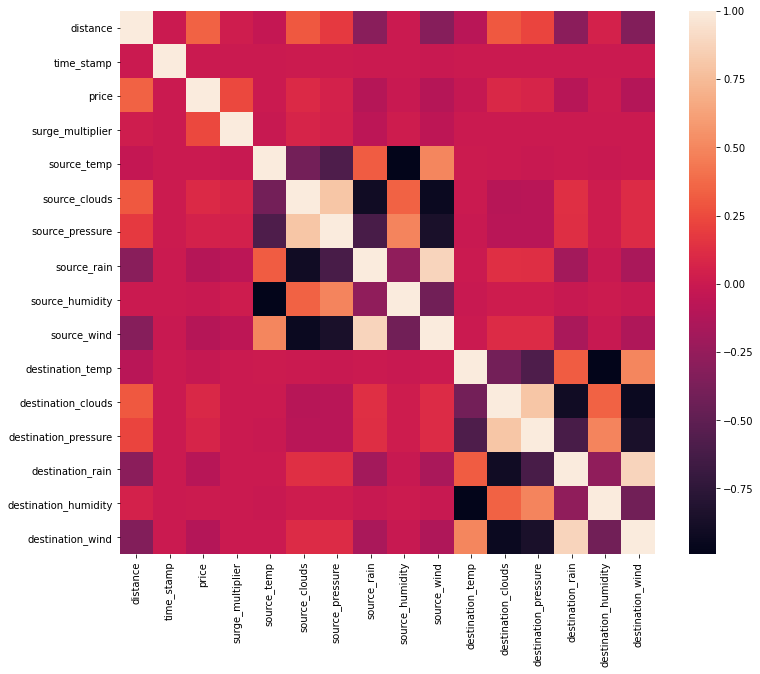

In [81]:
plt.figure(figsize=(12, 10))
sns.heatmap(data = data.corr())

Text(0.5, 1.0, 'Corelation (Price)')

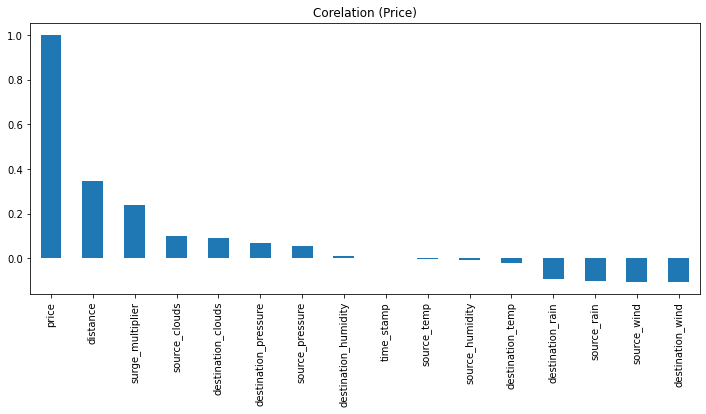

In [82]:
plt.figure(figsize=(12, 5))
data.corr()["price"].sort_values(ascending=False).plot(kind="bar")
plt.title("Corelation (Price)")

Prediction

In [83]:
def onehot_encode(df, column, prefix):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=prefix)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [84]:
def preprocess_data(df):
  df = df.copy()
  df = df.drop("id", axis=1)
  df['cab_type'] = df['cab_type'].replace({'Lyft': 1, 'Uber': 2})
  for column, prefix in [('destination', "dest"), ('source', "src"), ('product_id', "pid"), ('name', "nm")]:
    df = onehot_encode(df, column=column, prefix=prefix)
  

  X = df.drop("price", axis = 1)
  y = df["price"]
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, shuffle=True, random_state=1)

  scaler = StandardScaler()

  scaler.fit(X_train)

  X_train = pd.DataFrame(scaler.transform(X_train), columns = X.columns)
  X_test = pd.DataFrame(scaler.transform(X_test), columns = X.columns)

  return X_train, X_test, y_train, y_test, scaler

In [85]:
X_train, X_test, y_train, y_test, scaler = preprocess_data(data)

In [90]:
model = LinearRegression()
model.fit(X_train, y_train)

print("Test R^2 Score: {:.5f}".format(model.score(X_test, y_test)))

Test R^2 Score: 0.92804
